In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SQL
from sqlalchemy import create_engine

# mlflow
from mlflow.tracking import MlflowClient
import mlflow
import mlflow.sklearn

# preprocess / model
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# MLFLOW

In [2]:
# connect to localhost 
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_tracking_uri("#")
mlflow.get_tracking_uri() # This checks if it was set properly

# set experiment in MLFlow
mlflow.set_experiment("CL breast cancer")

# connect to MLFlow Client
client = MlflowClient()

<Experiment: artifact_location='file:///Users/veron/Desktop/Soutenance/mlflow_classifier/mlruns/1', experiment_id='1', lifecycle_stage='active', name='CL breast cancer', tags={}>

In [3]:
# connect to MLFlow Client
from mlflow.tracking import MlflowClient
client = MlflowClient()

# EDA / Cleaning


In [3]:
# read data
data = pd.read_csv('data/breast-cancer.csv',delimiter=',')

In [5]:
#delete colonne ID
data.drop(["id"],axis=1,inplace=True)

In [6]:
def all_info(df):
    print("-------------Top-5--------------")
    print(df.head())
    print()
    print("-----------Information-----------")
    print(df.info())
    print()
    print("-----------Data Types-----------")
    print(df.dtypes)
    print()
    print("----------Missing value-----------")
    print(df.isnull().sum())
    print()
    print("----------Null value-----------")
    print(df.isna().sum())
    print()
    print("----------Shape of Data----------")
    print(df.shape)
    print("----------Duplicate----------")
    print(df.duplicated().sum())
    
all_info(data)

-------------Top-5--------------
  diagnosis  radius_mean  texture_mean  ...  concave points_worst  symmetry_worst  fractal_dimension_worst
0         M        17.99         10.38  ...                0.2654          0.4601                  0.11890
1         M        20.57         17.77  ...                0.1860          0.2750                  0.08902
2         M        19.69         21.25  ...                0.2430          0.3613                  0.08758
3         M        11.42         20.38  ...                0.2575          0.6638                  0.17300
4         M        20.29         14.34  ...                0.1625          0.2364                  0.07678

[5 rows x 31 columns]

-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 


In [7]:
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [8]:
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

# Database SQL

In [ ]:
from sqlalchemy import create_engine

# database connection
hostname="127.0.0.1"
dbname="#"
uname="#"
pwd="#"

# create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=hostname, db=dbname, user=uname, pw=pwd))

# connect to the database
engine.connect() 

# upload dataframe in SQL base
data.to_sql('cancer', engine, index=False)

# Visualisation

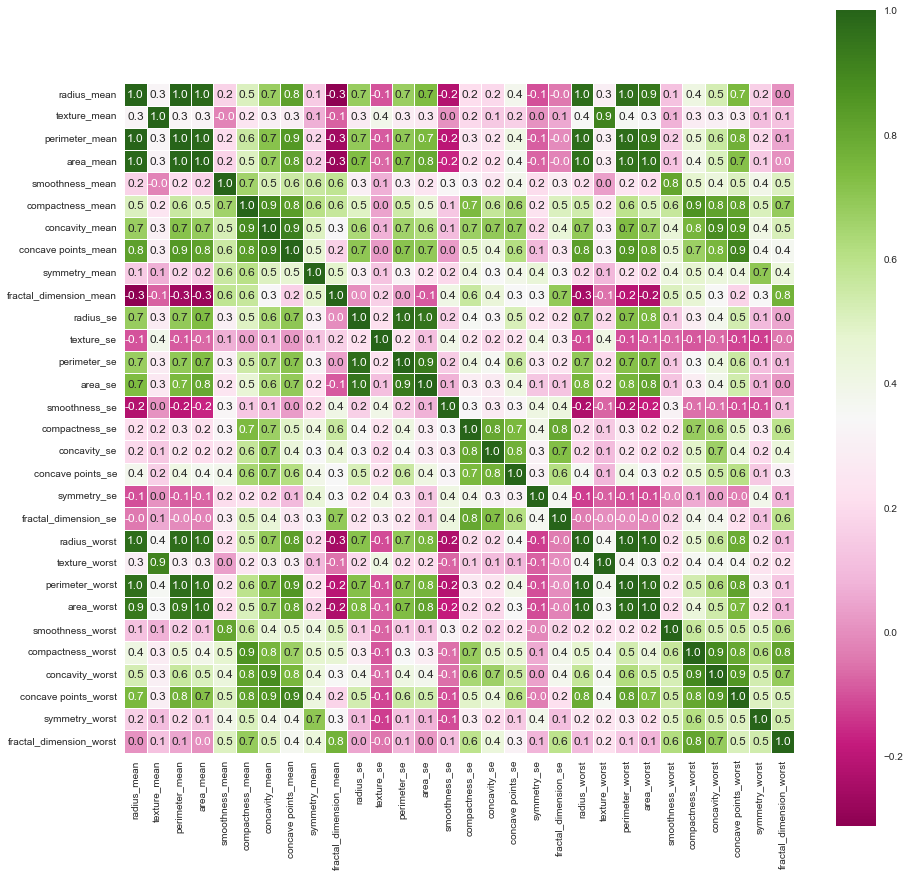

In [9]:
# check relationship between variables:
corr=data.corr()
f,ax=plt.subplots(figsize=(15,15))
sns.heatmap(corr,annot=True,linewidths=1,fmt=".1f",ax=ax,cmap="PiYG",square=True)
plt.show()

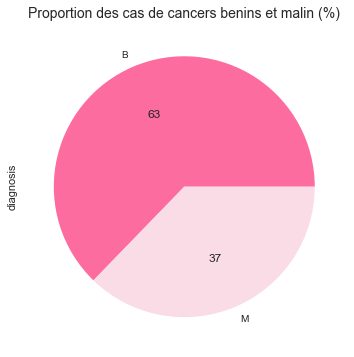

In [11]:
# target : "Target" / very unbalanced
plt.figure(figsize = (6,6))
plt.title('Proportion des cas de cancers benins et malin (%)', fontsize=14)
data['diagnosis'].value_counts().plot(kind='pie',autopct="%.0f", colors = ['#FD6C9E', "#FADCE6"])
plt.show()

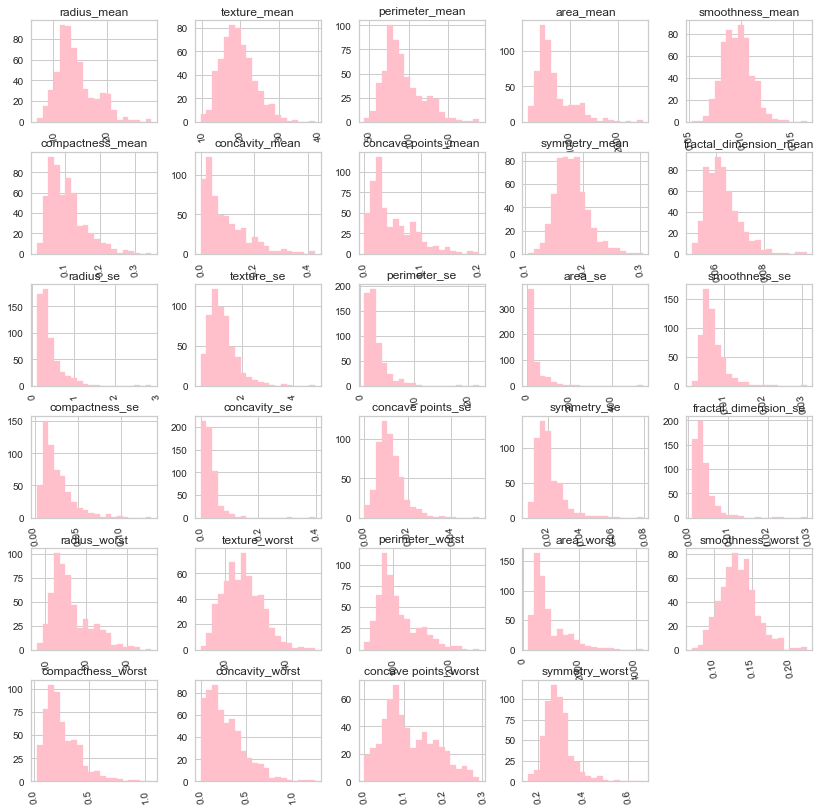

In [51]:
data.iloc[:, 1:30].hist(figsize=(14,14), xrot=100, bins=20,color = "pink", ec="pink")
plt.show()

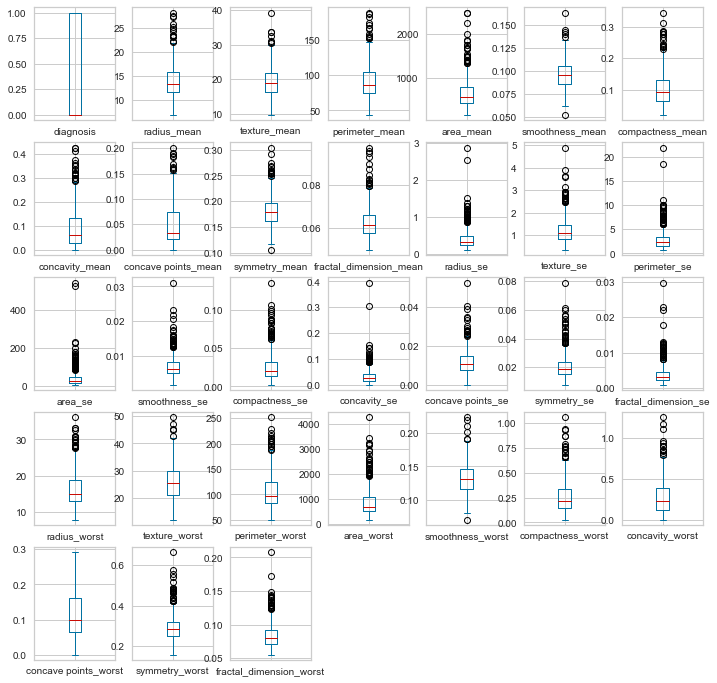

In [35]:
#individual boxplot
data.plot(kind='box', subplots=True, layout=(6, 7), figsize=(12, 12));

In [12]:
#encode the label into M = 1/ B = 0
data['diagnosis'] = (data['diagnosis'] == 'M').astype(int)

In [13]:
def outlier_function(df, col_name):
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
    
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
    
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [14]:
for column in data.columns:
    if outlier_function(data, column)[2] > 0:
        print("{} outlier(s) in {}".format(outlier_function(data,column)[2], column))

1 outlier(s) in radius_mean
1 outlier(s) in texture_mean
5 outlier(s) in area_mean
1 outlier(s) in smoothness_mean
1 outlier(s) in compactness_mean
1 outlier(s) in symmetry_mean
4 outlier(s) in fractal_dimension_mean
7 outlier(s) in radius_se
4 outlier(s) in texture_se
12 outlier(s) in perimeter_se
22 outlier(s) in area_se
7 outlier(s) in smoothness_se
6 outlier(s) in compactness_se
6 outlier(s) in concavity_se
3 outlier(s) in concave points_se
9 outlier(s) in symmetry_se
11 outlier(s) in fractal_dimension_se
1 outlier(s) in perimeter_worst
7 outlier(s) in area_worst
3 outlier(s) in compactness_worst
1 outlier(s) in concavity_worst
4 outlier(s) in symmetry_worst
2 outlier(s) in fractal_dimension_worst


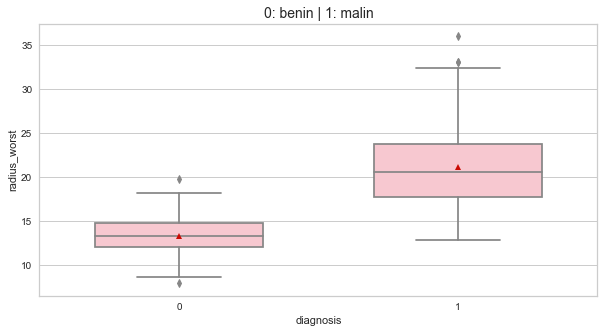

In [42]:
plt.figure(figsize=(10, 5))
plt.title('0: benin | 1: malin', fontsize=14)
sns.boxplot(x="diagnosis", y="radius_worst", data=data, color='pink', width=0.6, showmeans=True)
plt.show()

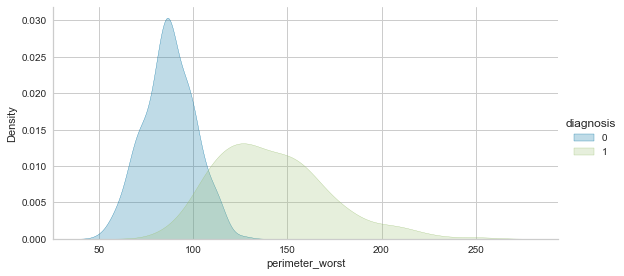

In [8]:

fig = sns.FacetGrid(data, hue="diagnosis", size=4, aspect=2) # aspect=3 permet d'allonger le graphique
fig.map(sns.kdeplot, "perimeter_worst", shade=True)
fig.add_legend()

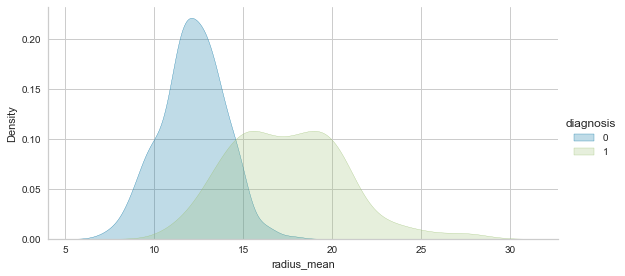

In [11]:

fig = sns.FacetGrid(data, hue="diagnosis", size=4, aspect=2) # aspect=3 permet d'allonger le graphique
fig.map(sns.kdeplot, "radius_mean", shade=True)
fig.add_legend()

# SMOTEENN + GridSearchCV + Random Forest

In [9]:
# definir X, y
y = data["diagnosis"]
#X = data.drop("diagnosis", axis=1)
X = data[["concave points_worst", "concave points_mean", "radius_worst", "perimeter_worst", "compactness_worst", "symmetry_worst", "texture_worst", "area_se", "concavity_mean", "area_worst", "texture_mean"]]

In [10]:
# standardizing the features (scaling)
X_std = MinMaxScaler().fit_transform(X)

In [11]:
# split
X_train, X_test, y_train, y_test = train_test_split(X_std,y,test_size=0.3)

In [12]:
smt = SMOTEENN(random_state=42)

X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

# concat in new dataframe
df_smt = pd.concat([pd.DataFrame(y_train_smt), pd.DataFrame(X_train_smt)], axis=1)

In [13]:
# tuning
from sklearn.model_selection import GridSearchCV

# Random Forest Classifier with GrindSearchCV

# model
model_rf3 = RandomForestClassifier()

param_grid = {'n_estimators': [50, 100, 150, 200, 400],
              'max_depth': [2, 4, 6, 8, 10]
             }

#gridsearch cv
grid = GridSearchCV(model_rf3, param_grid=param_grid, cv=5, scoring='accuracy',verbose=3)

#fit
grid.fit(X_train_smt, y_train_smt)

# score & best parameters
print(grid.best_score_)
print(grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ......max_depth=2, n_estimators=50;, score=0.989 total time=   0.1s
[CV 2/5] END ......max_depth=2, n_estimators=50;, score=0.978 total time=   0.1s
[CV 3/5] END ......max_depth=2, n_estimators=50;, score=0.966 total time=   0.1s
[CV 4/5] END ......max_depth=2, n_estimators=50;, score=1.000 total time=   0.1s
[CV 5/5] END ......max_depth=2, n_estimators=50;, score=0.977 total time=   0.1s
[CV 1/5] END .....max_depth=2, n_estimators=100;, score=0.989 total time=   0.3s
[CV 2/5] END .....max_depth=2, n_estimators=100;, score=0.989 total time=   0.3s
[CV 3/5] END .....max_depth=2, n_estimators=100;, score=0.966 total time=   0.4s
[CV 4/5] END .....max_depth=2, n_estimators=100;, score=1.000 total time=   0.3s
[CV 5/5] END .....max_depth=2, n_estimators=100;, score=0.977 total time=   0.3s
[CV 1/5] END .....max_depth=2, n_estimators=150;, score=0.989 total time=   0.4s
[CV 2/5] END .....max_depth=2, n_estimators=150

[CV 2/5] END .....max_depth=10, n_estimators=50;, score=0.989 total time=   0.1s
[CV 3/5] END .....max_depth=10, n_estimators=50;, score=0.978 total time=   0.1s
[CV 4/5] END .....max_depth=10, n_estimators=50;, score=1.000 total time=   0.1s
[CV 5/5] END .....max_depth=10, n_estimators=50;, score=0.989 total time=   0.1s
[CV 1/5] END ....max_depth=10, n_estimators=100;, score=0.989 total time=   0.4s
[CV 2/5] END ....max_depth=10, n_estimators=100;, score=0.989 total time=   0.3s
[CV 3/5] END ....max_depth=10, n_estimators=100;, score=0.978 total time=   0.3s
[CV 4/5] END ....max_depth=10, n_estimators=100;, score=1.000 total time=   0.3s
[CV 5/5] END ....max_depth=10, n_estimators=100;, score=0.977 total time=   0.3s
[CV 1/5] END ....max_depth=10, n_estimators=150;, score=0.989 total time=   0.5s
[CV 2/5] END ....max_depth=10, n_estimators=150;, score=1.000 total time=   0.6s
[CV 3/5] END ....max_depth=10, n_estimators=150;, score=0.978 total time=   0.6s
[CV 4/5] END ....max_depth=1

In [104]:
model = grid.best_estimator_
y_pred = model.predict(X_test)

# score (precision, accuracy, recall, F1)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)

# precision
precision = precision_score(y_test, y_pred)
# recall
recall = recall_score(y_test, y_pred)
# F1 score
F1 = f1_score(y_test, y_pred)
#AUC
auc = roc_auc_score(y_test,y_pred)

print("Classification report:\n\n", class_report)
print("Confusion Matrix\n",conf_matrix)
print("\nAccuracy\n",acc)
print("\nPrecision\n",precision)
print("\nRecall\n",recall)
print("\nF1\n",F1)
print("\nAUC\n",auc)


Classification report:

               precision    recall  f1-score   support

           0       0.97      0.94      0.95       109
           1       0.89      0.95      0.92        62

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Confusion Matrix
 [[102   7]
 [  3  59]]

Accuracy
 0.9415204678362573

Precision
 0.8939393939393939

Recall
 0.9516129032258065

F1
 0.921875

AUC
 0.943696359869784


<AxesSubplot:>

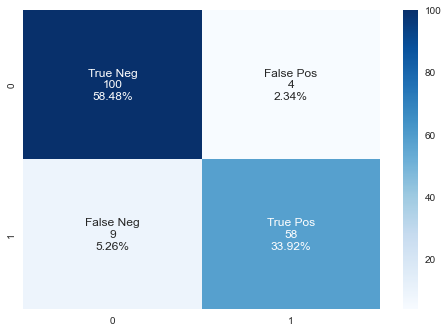

In [63]:
# confusion matrix
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='',cmap='Blues')

[0.         0.03809524 1.        ] [0.         0.98484848 1.        ]
97.33766233766235


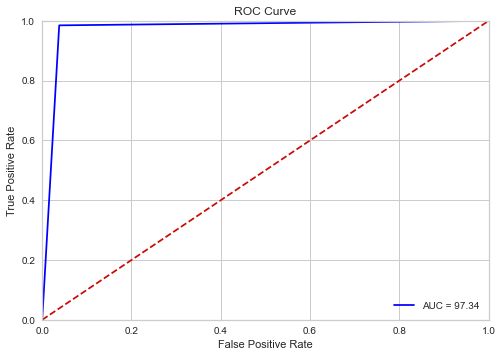

In [12]:
from sklearn.metrics import roc_curve,auc
fp, tp, thresholds=roc_curve(y_test,y_pred,pos_label=1)
print(fp, tp)
AUC=auc(fp, tp)*100
print(AUC)

#tracer tp en fonction de fp
import matplotlib.pyplot as plt
plt.plot(fp, tp, color='blue',label = 'AUC = %0.2f' % AUC)
plt.title('ROC Curve')
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

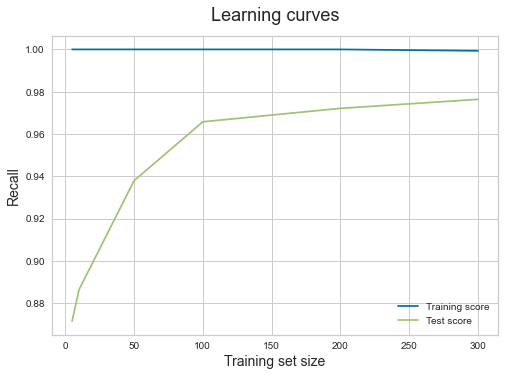

In [16]:
# learning curve
from sklearn.model_selection import learning_curve

# Get train scores, train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(estimator = model,
                                          X = X_train_smt,
                                          y = y_train_smt,
                                          train_sizes = [5,10,50,100,200,300],
                                          cv = 5,
                                          shuffle = True,
                                          random_state=3)

# take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# plot the learning curves
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('Recall', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [ ]:
# register model in MLFLOW
#client.create_registered_model("ACP-logistic-regression")

model_name = "Features Selection SMT GS RF"

with mlflow.start_run() as run:
  #run_num = run.info.run_id
  #model_uri = "runs:/{run_id}/{artifact_path}".format(run_id=run_num, artifact_path=model_name)
  mlflow.set_tag("mlflow.runName", "2 Features Selection SMT GS RF")
  mlflow.set_tag("mlflow.user", "Cerise")
  mlflow.log_metric('Accuracy', acc)
  mlflow.log_metric('Recall', recall)
  mlflow.log_metric('Precision', precision)
  mlflow.log_metric('F1-Score', F1)
  mlflow.sklearn.log_model(model, model_name)

In [64]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=["feature_importance"], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

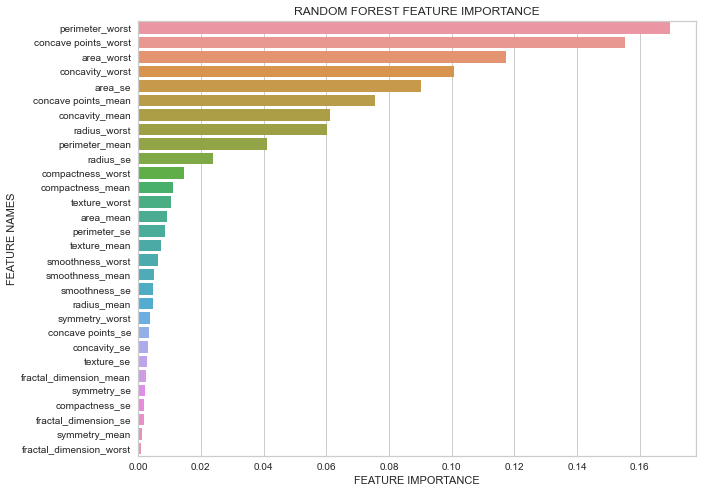

In [65]:
plot_feature_importance(model.feature_importances_,X.columns, 'RANDOM FOREST ')

In [105]:
# register model in MLFLOW
#client.create_registered_model("ACP-logistic-regression")

model_name = "Model app"

with mlflow.start_run() as run:
  #run_num = run.info.run_id
  #model_uri = "runs:/{run_id}/{artifact_path}".format(run_id=run_num, artifact_path=model_name)
  mlflow.set_tag("mlflow.runName", "Model app")
  mlflow.set_tag("mlflow.user", "Cerise")
  mlflow.log_metric('Accuracy', acc)
  mlflow.log_metric('Recall', recall)
  mlflow.log_metric('Precision', precision)
  mlflow.log_metric('F1-Score', F1)
  mlflow.sklearn.log_model(model, model_name)

# SHAP / XGBoost

In [88]:
import xgboost as xgb
from xgboost import XGBClassifier

# definir X, y
y = data["diagnosis"]
X = data[["concave points_worst", "concave points_mean", "radius_worst", "perimeter_worst", "compactness_worst", "symmetry_worst", "texture_worst", "area_se", "concavity_mean", "area_worst", "texture_mean"]]

# standardizing the features (scaling)
X_std = StandardScaler().fit_transform(X)

# split
X_train, X_test, y_train, y_test = train_test_split(X_std,y,test_size=0.3)

smt = SMOTEENN(random_state=42)

X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

# concat in new dataframe
df_smt = pd.concat([pd.DataFrame(y_train_smt), pd.DataFrame(X_train_smt)], axis=1)

# model
model = XGBClassifier()

model.fit(X_train_smt, y_train_smt)

# prediction
y_pred = model.predict(X_test)

# score (precision, accuracy, recall, F1)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)

# precision
precision = precision_score(y_test, y_pred)
# recall
recall = recall_score(y_test, y_pred)
# F1 score
F1 = f1_score(y_test, y_pred)
#AUC
auc = roc_auc_score(y_test,y_pred)

print("Classification report:\n\n", class_report)
print("Confusion Matrix\n",conf_matrix)
print("\nAccuracy\n",acc)
print("\nPrecision\n",precision)
print("\nRecall\n",recall)
print("\nF1\n",F1)
print("\nAUC\n",auc)

[16:07:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification report:

               precision    recall  f1-score   support

           0       0.97      0.99      0.98        99
           1       0.99      0.96      0.97        72

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.98       171
weighted avg       0.98      0.98      0.98       171

Confusion Matrix
 [[98  1]
 [ 3 69]]

Accuracy
 0.9766081871345029

Precision
 0.9857142857142858

Recall
 0.9583333333333334

F1
 0.971830985915493

AUC
 0.9741161616161618


<AxesSubplot:>

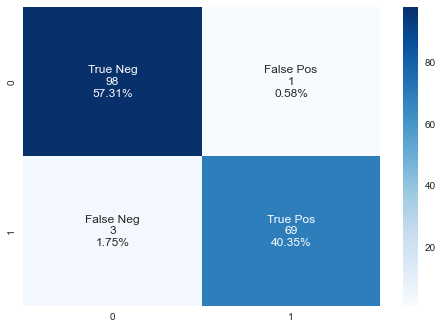

In [89]:
# confusion matrix
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='',cmap='Blues')

[0.         0.01010101 1.        ] [0.         0.95833333 1.        ]
97.41161616161618


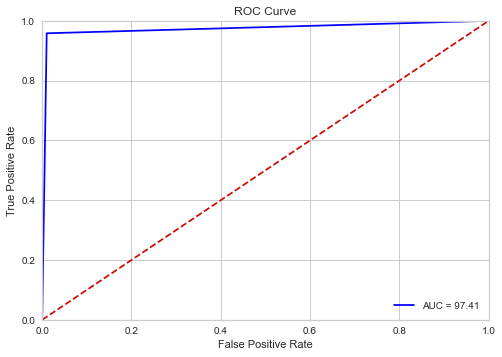

In [90]:
from sklearn.metrics import roc_curve,auc
fp, tp, thresholds=roc_curve(y_test,y_pred,pos_label=1)
print(fp, tp)
AUC=auc(fp, tp)*100
print(AUC)

#tracer tp en fonction de fp
import matplotlib.pyplot as plt
plt.plot(fp, tp, color='blue',label = 'AUC = %0.2f' % AUC)
plt.title('ROC Curve')
#plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

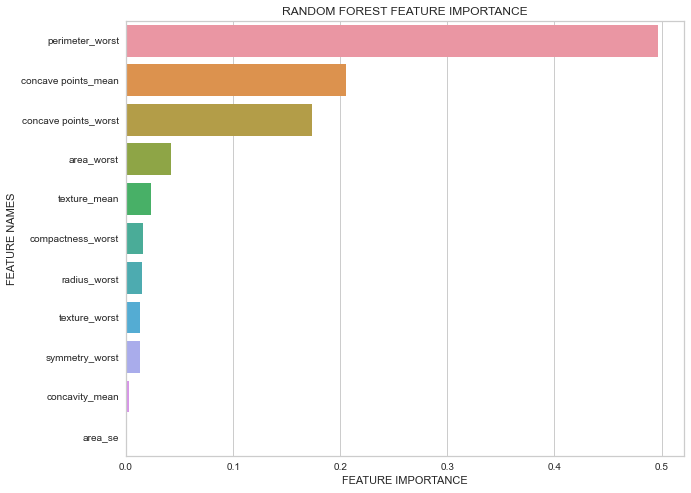

In [76]:
plot_feature_importance(model.feature_importances_,X.columns, 'RANDOM FOREST ')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

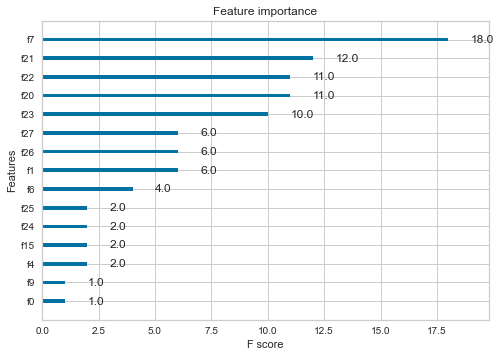

In [70]:
xgb.plot_importance(model)

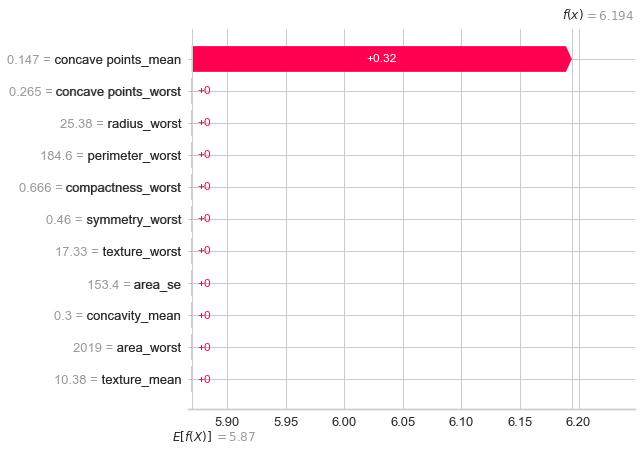

In [78]:
import shap

explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# visualize the prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=30, show=True)

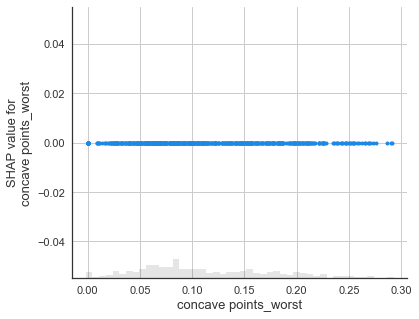

In [80]:
shap.plots.scatter(shap_values[:,"concave points_worst"])

In [19]:
shap.initjs()
shap.plots.force(shap_values[0])

In [42]:
shap.initjs()
shap.plots.force(shap_values)

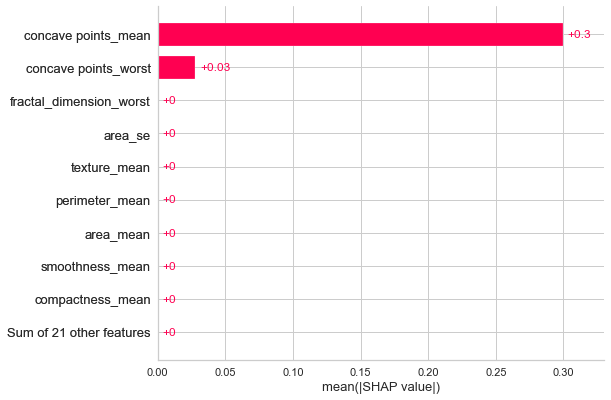

In [43]:
shap.plots.bar(shap_values)